## RANSAC regression algorithm for differentiating outliers for a better model

### Load libraries and data

In [1]:
# importing relevant libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Import plotyly
import plotly.express as px

# Import state abbreviations and FIPS
from state_names import state_abbreviations, state_to_fips

### Functions to test this data

In [2]:
# Robustly fit linear model with RANSAC algorithm
def ransac_linear(X_train, y_train, X_test, y_test, data_df=pd.DataFrame(), seed=None):
    ransac = RANSACRegressor(max_trials=500, min_samples=30000, loss='squared_error')

    if seed is not None:
        ransac = RANSACRegressor(random_state=seed, max_trials=500, min_samples=30000, loss='squared_error')
    
    ransac.fit(X_train, y_train)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    y_pred = ransac.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred)
    r2_train = ransac.score(X_train, y_train)

    # print(f"Mean Squared Error Train: {mse_train}")
    # print(f"R-squared Train: {r2_train}")

    y_pred = ransac.predict(X_test)

    # Evaluating the model
    mse_test = mean_squared_error(y_test, y_pred)
    r2_test = ransac.score(X_test, y_test)

    # print(f"Mean Squared Error Test: {mse_test}")
    # print(f"R-squared Test: {r2_test}")
    outlier_count = -1
    if not data_df.empty:
        outlier_mask = np.logical_not(ransac.inlier_mask_)
        data_df['Is_Outlier'] = outlier_mask
        outlier_count = data_df[data_df['Is_Outlier'] == True].shape[0]
    else: 
        print("The dataframe you passed in was empty.")
    
    print("Outlier count: ", outlier_count)

    return mse_train, mse_test, r2_train, r2_test, data_df, outlier_count, ransac.estimator_.coef_

def run_several_ransac_linear(n_to_run, X_train, y_train, X_test, y_test, data_df=pd.DataFrame()):
    mse_trains = []
    mse_tests = []
    r2_trains = []
    r2_tests = []
    outlier_count = []
    if data_df.empty:
        print("Warning -- the dataframe is empty.")
    for x in range(n_to_run):
        results = ransac_linear(X_train, y_train, X_test, y_test, data_df, x)
        mse_trains.append(results[0])
        mse_tests.append(results[1])
        r2_trains.append(results[2])
        r2_tests.append(results[3])
        outlier_count.append(results[5])


    print(r2_tests)
    print(outlier_count)
    print("")
    print("Mean MSE Train: ", sum(mse_trains)/len(mse_trains))
    print("Mean R2 Train: ", sum(r2_trains)/len(r2_trains))
    print("Mean MSE Test: ", sum(mse_tests)/len(mse_tests))
    print("Mean R2 Test: ", sum(r2_tests)/len(r2_tests))

### Load Data

In [3]:
data = pd.read_csv("all_data.csv", index_col=0)
data.drop(columns=['Date'], inplace=True)
data.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)
data['StateFPS'] = data['StateAbbrv'].map(state_to_fips)
print(data.shape)
data.head()

(596366, 18)


,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.93,8.01,15,103.0,173.6,64.7,7.0,06
1,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.81,8.20,30,129.9,166.8,81.1,61.1,06
2,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.93,8.01,15,103.0,173.6,64.7,7.0,17
3,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.81,8.20,30,129.9,166.8,81.1,61.1,17
4,2000,1,Harris County,TX,61195.175569,217850.462915,57.4,5.6,51.8,TX,0.93,8.01,15,103.0,173.6,64.7,7.0,48


In [4]:
def scale_data(data):
    columns_to_scale = data.drop(columns=['Year', 'Month', 'RegionName', 'State', 'StateFPS', 'StateAbbrv']).columns

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the specified columns
    scaler.fit(data[columns_to_scale])

    # Transform the data using the fitted scaler and convert it back to a DataFrame
    scaled_data = scaler.transform(data[columns_to_scale])
    scaled_data_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=data.index)
    scaled_data_df['Year'] = data['Year']
    scaled_data_df['Month'] = data['Month']
    scaled_data_df['RegionName'] = data['RegionName']
    scaled_data_df['State'] = data['State']
    scaled_data_df['StateFPS'] = data['StateFPS']
    scaled_data_df['StateAbbrv'] = data['StateAbbrv']

    return scaled_data_df

scaled_data_df = scale_data(data)
# Display the first few rows of the DataFrame to check the results
scaled_data_df.head()

,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),Year,Month,RegionName,State,StateFPS,StateAbbrv
0,0.428594,0.541353,-0.199870,0.918986,-0.382595,0.107782,2.473531,-1.0,-2.005074,-2.348182,-0.912256,-1.040555,2000,1,Los Angeles County,CA,06,CA
1,0.428594,0.541353,-0.199870,0.918986,-0.382595,-0.220832,2.627564,1.0,-1.278000,-2.532864,1.004473,0.813446,2000,1,Los Angeles County,CA,06,CA
2,-0.358717,0.076182,-1.803017,0.297918,-1.866275,0.107782,2.473531,-1.0,-2.005074,-2.348182,-0.912256,-1.040555,2000,1,Cook County,IL,17,IL
3,-0.358717,0.076182,-1.803017,0.297918,-1.866275,-0.220832,2.627564,1.0,-1.278000,-2.532864,1.004473,0.813446,2000,1,Cook County,IL,17,IL
4,-0.520283,-0.324795,0.098526,1.244308,-0.148021,0.107782,2.473531,-1.0,-2.005074,-2.348182,-0.912256,-1.040555,2000,1,Harris County,TX,48,TX


In [5]:
# Loading the shapefile in order to visualize clean data on the US map
def merge_dfs(us_counties, data):
    data = us_counties.merge(data, left_on=['NAMELSAD', 'STATEFP'], right_on=['RegionName', 'StateFPS'])
    return data

us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merge_dfs(us_counties, data)
merged_scaled_data_df = merge_dfs(us_counties, scaled_data_df)
merged_scaled_data_df.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),Year,Month,RegionName,State,StateFPS,StateAbbrv
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-2.005074,-2.348182,-0.912256,-1.040555,2000,1,Lancaster County,NE,31,NE
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-1.278000,-2.532864,1.004473,0.813446,2000,1,Lancaster County,NE,31,NE
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-2.072646,-2.369909,-1.099254,-1.033701,2000,2,Lancaster County,NE,31,NE
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-1.334761,-2.617057,1.016160,0.727772,2000,2,Lancaster County,NE,31,NE
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-2.053726,-2.258557,-1.146003,-1.033701,2000,3,Lancaster County,NE,31,NE


In [6]:
merged_data.shape

(579894, 36)

### Split the data

In [7]:
def split_data(data):
    test = data[data['Year'] == 2019].copy()
    train = data[data['Year'] != 2019].copy()
    y_test = test['Purchase Price ($thou)'].copy()
    y_train = train['Purchase Price ($thou)'].copy()
    X_train = train.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                        'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                        'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
    X_test = test.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                        'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                        'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
    return X_train, y_train, X_test, y_test, train, test

X_train, y_train, X_test, y_test, train, test = split_data(merged_data)
scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test, scaled_train, scaled_test = split_data(merged_scaled_data_df)

Feature selection from my Linear Regression revealed these features should be dropped. Let's keep this handy to try.

In [8]:
train_scaled_selected = scaled_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

X_train_selected = X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
X_test_selected = X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

scaled_X_train_selected = scaled_X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
scaled_X_test_selected = scaled_X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

### Run the RANSAC model 

#### Raw Data
First I want to check what this model looks like on the data with no feature selection done or scaling.

In [9]:
run_several_ransac_linear(3, X_train, y_train, X_test, y_test, train)

Outlier count:  210830
Outlier count:  209871
Outlier count:  209045
[0.6805898091539133, 0.6796702856218957, 0.6769478048859938]
[210830, 209871, 209045]

Mean MSE Train:  48.99533096447063
Mean R2 Train:  0.9624585506641411
Mean MSE Test:  31.743072817918957
Mean R2 Test:  0.6790692998872676


This is not particularly impressive. On the other end of the spectrum, I will run the same model with the scaled data and features that were selected for the linear regression model from the previous sprint. (It might be true that different features should be selected for this model -- but I understand why these particular features complement each other well, so I think it's a good first pass guess.) 

In [10]:
run_several_ransac_linear(3, scaled_X_train_selected, scaled_y_train, scaled_X_test_selected, \
    scaled_y_test, train_scaled_selected)

Outlier count:  4557
Outlier count:  4557
Outlier count:  4557
[0.7954034818639144, 0.7954034818639144, 0.7954034818639144]
[4557, 4557, 4557]

Mean MSE Train:  0.03952346112170712
Mean R2 Train:  0.958943739332629
Mean MSE Test:  0.014926839291876
Mean R2 Test:  0.7954034818639144


This is already a lot better -- but having exactly 4557 outliers during all of the runs is a bit suspicious. What's going on there?

Instead of running 3, I am going to run it once and access the results.

In [11]:
results = ransac_linear(scaled_X_train_selected, scaled_y_train, scaled_X_test_selected, \
    scaled_y_test, train_scaled_selected, 3)

Outlier count:  4557


Below I want to see if there are any particular years that stand out. (Hint, hint).

In [12]:
selected_features_ransac_results = results[4]
outliers = selected_features_ransac_results[selected_features_ransac_results['Is_Outlier']]
outliers['Year'].unique()

array([2008, 2012], dtype=int64)

As suspected!! 2008 and 2012 contain ALL of the outliers of this dataset after feature selection. Going back to the raw data, I am going to run all of this again but without those 2 years, which experienced anomalous housing data that has already been well studied and is not believed to be related to climate change.

In [13]:
# Remove 2008 and 2012 from the data
mask = ~data['Year'].isin([2008, 2012])
data_no_2008 = data[mask]
data_no_2008['Year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2010, 2011,
       2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

We can't just drop all 2008 and all 2012 data from our original dataframe without having to do it for all variants of test, train, and original data. Instead, I'm going to go back to the beginning with our original dataset and redo the merging, scaling and splitting.

In [14]:
scaled_data_df_no_2008 = scale_data(data_no_2008)
merged_data_no_2008 = merge_dfs(us_counties, data_no_2008)
merged_scaled_data_df_no_2008 = merge_dfs(us_counties, scaled_data_df_no_2008)

X_train_no_2008, y_train_no_2008, X_test_no_2008, y_test_no_2008, \
    train_no_2008, test_no_2008 = split_data(merged_data_no_2008)
    
scaled_X_train_no_2008, scaled_y_train_no_2008, scaled_X_test_no_2008,\
      scaled_y_test_no_2008, scaled_train_no_2008, scaled_test_no_2008 \
        = split_data(merged_scaled_data_df_no_2008)

train_scaled_selected_no_2008 = scaled_train_no_2008.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

train_selected_no_2008 = train_no_2008.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

X_train_selected_no_2008 = X_train_no_2008.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
X_test_selected_no_2008 = X_test_no_2008.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

scaled_X_train_selected_no_2008 = scaled_X_train_no_2008.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
scaled_X_test_selected_no_2008 = scaled_X_test_no_2008.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

First, let's try the raw, unscaled data that simply doesn't have 2008 and 2012 data. What does this look like?

In [15]:
run_several_ransac_linear(3, X_train_no_2008, y_train_no_2008, X_test_no_2008, \
    y_test_no_2008, train_no_2008)

Outlier count:  161919
Outlier count:  161299
Outlier count:  160414
[0.774897227974517, 0.7767190788792351, 0.7793151344706153]
[161919, 161299, 160414]

Mean MSE Train:  33.28142040281782
Mean R2 Train:  0.9747487781454008
Mean MSE Test:  22.059063395680514
Mean R2 Test:  0.7769771471081225


This is not the worst regression. The RANSAC algorithm left out roughly 16100 datapoints that it is calling outliers.

Next, let's look at the same with scaled data.

In [16]:
run_several_ransac_linear(3, scaled_X_train_no_2008, scaled_y_train_no_2008, scaled_X_test_no_2008, \
    scaled_y_test_no_2008, scaled_train_no_2008)

Outlier count:  0


Outlier count:  0
Outlier count:  0
[0.71289572509627, 0.71289572509627, 0.71289572509627]
[0, 0, 0]

Mean MSE Train:  0.022567589108525698
Mean R2 Train:  0.976446281143167
Mean MSE Test:  0.020643512019162424
Mean R2 Test:  0.7128957250962701


The fact that scaling causes the R squared value to drop for the test data AND doesn't classify anything as an outlier now is not surprising. Scaling via standard scalar necessarily means everything won't be an outlier.

In [17]:
run_several_ransac_linear(3, scaled_X_train_selected_no_2008, scaled_y_train_no_2008, scaled_X_test_selected_no_2008, \
    scaled_y_test_no_2008, train_scaled_selected_no_2008)

Outlier count:  0
Outlier count:  0
Outlier count:  0
[0.8075796380016151, 0.8075796380016151, 0.8075796380016151]
[0, 0, 0]

Mean MSE Train:  0.024692484186890146
Mean R2 Train:  0.9742285351076742
Mean MSE Test:  0.013835502996175126
Mean R2 Test:  0.8075796380016151


In [18]:
run_several_ransac_linear(3, X_train_selected_no_2008, y_train_no_2008, X_test_selected_no_2008, \
    y_test_no_2008, train_selected_no_2008.copy())

Outlier count:  175391
Outlier count:  174576
Outlier count:  172497
[0.799193022767669, 0.7983660078263783, 0.8032789516787868]
[175391, 174576, 172497]

Mean MSE Train:  36.88789810906925
Mean R2 Train:  0.9720124776037776
Mean MSE Test:  19.754258008311282
Mean R2 Test:  0.800279327424278


OK -- THIS is very interesting. If we _don't_ scale the data (or, moving forward if I tried MinMax Scalar as Yoko suggests), we still see a lot of outliers AND a very good R squared value. 

Let's explore those outliers a little further.

In [19]:
mse_train, mse_test, r2_train, r2_test, results, outlier_count, coefs \
     = ransac_linear(X_train_selected_no_2008, y_train_no_2008, X_test_selected_no_2008, \
    y_test_no_2008, train_selected_no_2008, 2)

results['Is_Outlier'].value_counts()

Outlier count:  172497


Is_Outlier
False    331855
True     172497
Name: count, dtype: int64

In [20]:
# I know that Month was removed for feature selection but it is necessary for plotting.
results['Month'] = train_no_2008['Month']

<Axes: >

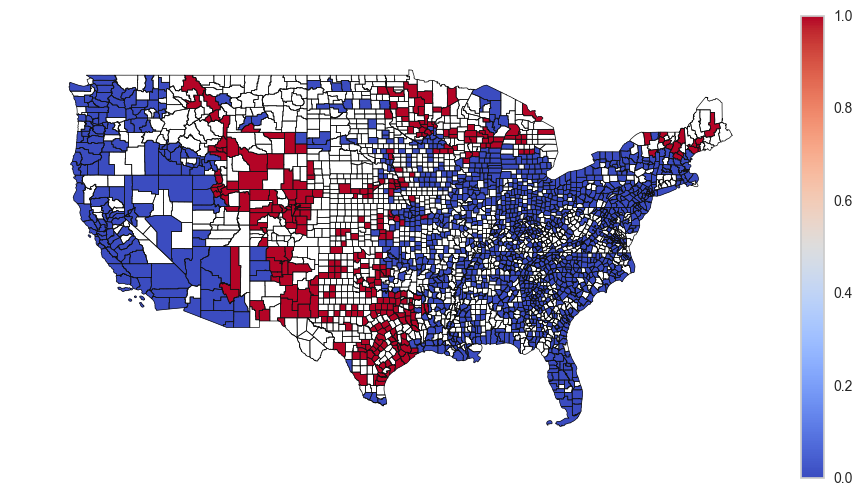

In [21]:
data_2018 = results.copy()
data_2018 = data_2018[data_2018['Year'] == 2018]
data_2018 = data_2018[data_2018['Month'] == 3]
data_2018['Is_Outlier'] = data_2018['Is_Outlier'].astype(dtype='int')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
data_2018.plot(column='Is_Outlier', ax=ax, cmap='coolwarm', legend=True)

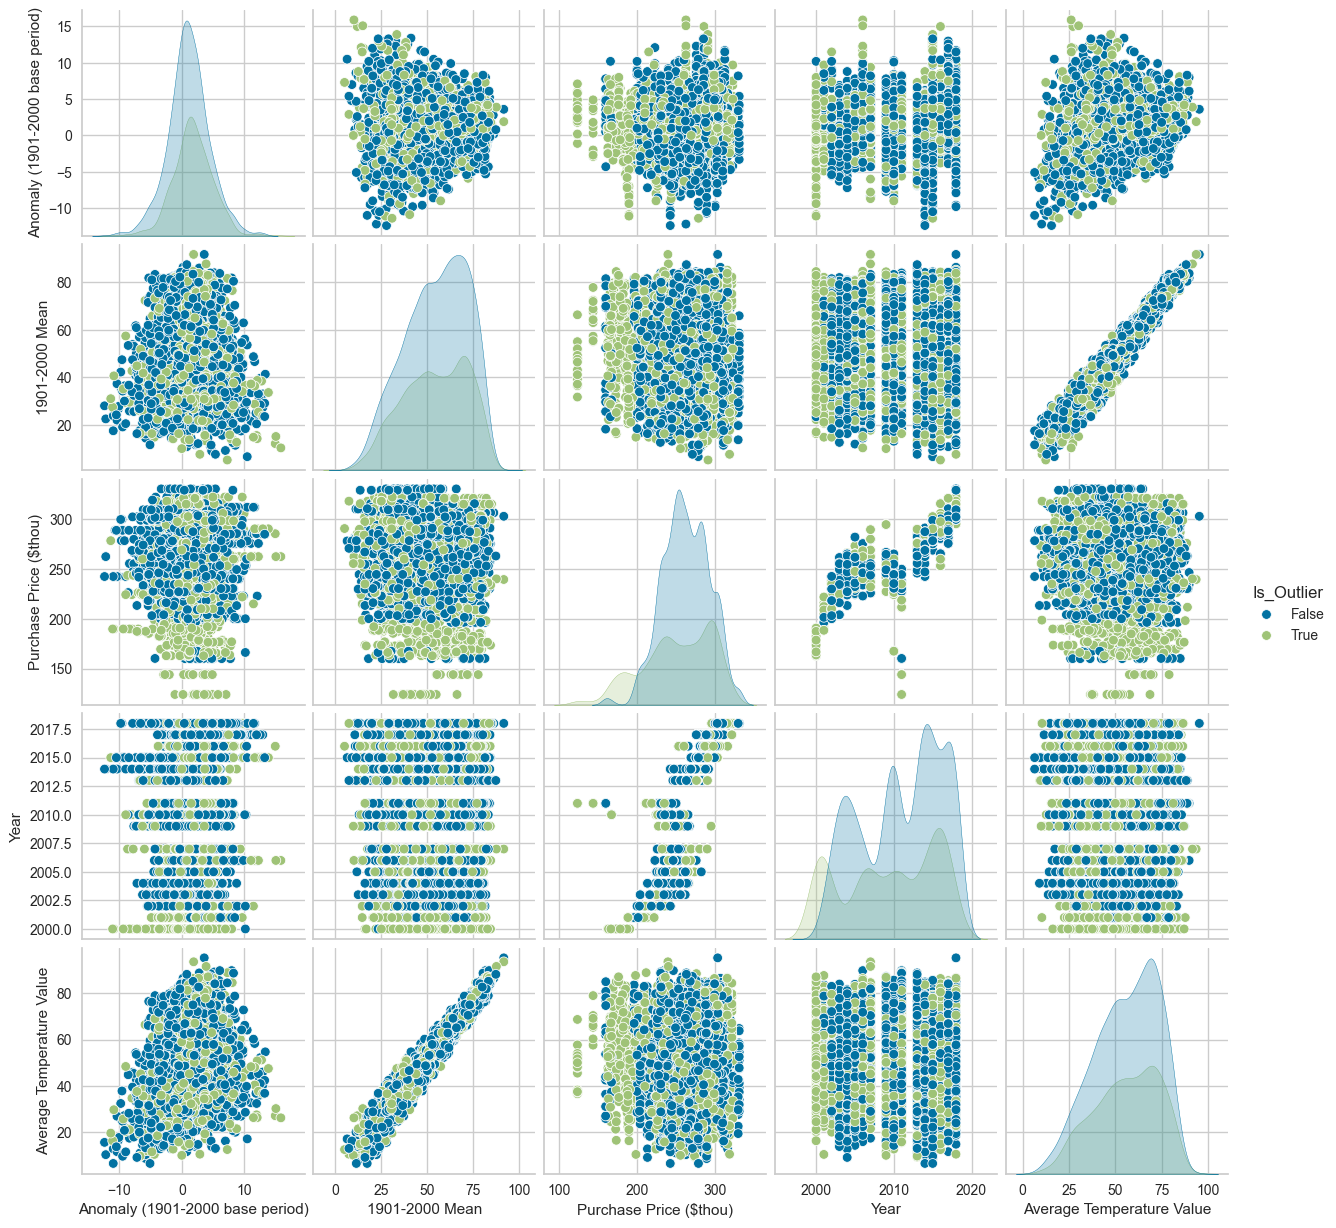

In [22]:
s = results[['Anomaly (1901-2000 base period)', '1901-2000 Mean', 'Purchase Price ($thou)', 'Year', 'Average Temperature Value', 'Is_Outlier']].sample(5000)
sns.pairplot(data=s, hue='Is_Outlier')

In [23]:
data = pd.read_csv("all_data.csv", index_col=0)
data['Is_Outlier'] = results['Is_Outlier']

In [24]:
data.to_csv("all_data_w_outliers.csv")

## References
1. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py